# Predict Next Purchase

In [1]:
%matplotlib inline
import composeml as cp
import data

## Load Data

In [2]:
df = data.load_orders('data', nrows=int(1e+5))
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,user_id
order_time,,,,,,,,,
2015-01-01 09:00:00,3031,33120,2,1,Organic Egg Whites,86,16,dairy eggs,2555
2015-01-07 18:00:00,3031,27086,1,1,Half & Half,53,16,dairy eggs,2555
2015-02-04 18:00:00,5640,33120,9,1,Organic Egg Whites,86,16,dairy eggs,155
2015-03-04 18:00:00,5640,12384,6,1,Organic Lactose Free 1% Lowfat Milk,91,16,dairy eggs,155
2015-04-01 18:00:00,5640,47209,7,1,Organic Hass Avocado,24,4,produce,155


## Generate Labels

### Create Labeling Function

In [3]:
def bought_product(df, product_name):
    was_purchased = df.product_name.eq(product_name).any()
    return was_purchased

### Construct Label Maker

In [4]:
lm = cp.LabelMaker(
    target_entity='user_id',
    time_index='order_time',
    labeling_function=bought_product,
    window_size='4w',
)

### Search Labels

In [5]:
lt = lm.search(
    df,
    product_name='Banana',
    num_examples_per_instance=10,
    verbose=True,
)
lt.head()

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| user_id: 2800/2800 


,user_id,cutoff_time,bought_product
label_id,,,
0,27,2016-11-04 08:00:00,False
1,27,2016-11-05 18:00:00,False
2,27,2016-11-07 04:00:00,False
3,27,2016-11-08 14:00:00,False
4,27,2016-11-10 00:00:00,False


### Describe Labels

Label Distribution
------------------
False     33
True       6
Total:    39


Settings
--------
num_examples_per_instance    10
minimum_data                  0
window_size                  4w
gap                           1


Transforms
----------
No transforms applied



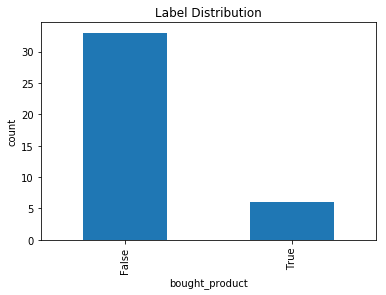

In [6]:
lt.describe()
lt.plot.distribution();